In [1]:
import pandas as pd
import foursquare
import math
#from foursquare_labeling.place_labelling import FoursquareHandler
import foursquare as fs 

import geopandas as gpd

from tqdm import tqdm_notebook


import os
from datetime import datetime
import pickle
import time

In [2]:
FOURSQUARE_API_CLIENT_ID='PGK4HA0FSSWA0RXOXEOPC4RETYNFSRCP3BSEVZOQVZGUZWCJ'
FOURSQUARE_API_CLIENT_SECRET='HJ4IHWYAZQXFAZQNVJ0HISMWD4T0OEEPUHLUJ35BGXS05VME'

In [3]:
province_gdf = gpd.read_file(os.path.join('data', 'provinces_with_code.geojson'), encoding='utf-8').to_crs({'init': 'epsg:25830'})
province_gdf.head()

C:\Users\ucam\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,NATCODE,NAMEUNIT,CODEUNIT,geometry
0,34104600000,València/Valencia,46,"MULTIPOLYGON (((653037.661 4429500.236, 652229..."
1,34084500000,Toledo,45,"POLYGON ((294238.465 4416957.428, 294235.467 4..."
2,34024400000,Teruel,44,"POLYGON ((765333.011 4512252.351, 764732.031 4..."
3,34094300000,Tarragona,43,"MULTIPOLYGON (((813560.435 4504876.753, 813537..."
4,34074200000,Soria,42,"POLYGON ((583890.589 4603311.305, 583939.589 4..."


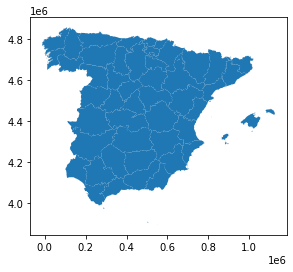

In [4]:
province_gdf.plot();

In [5]:
def get_new_point(lat, lon, d, brng):
    R = 6378.1 #Radius of the Earth
    #brng = 3.1415 #1.57 #Bearing is 90 degrees converted to radians.
    #d = 15 #Distance in km

    #lat1 = math.radians(52.20472) #Current lat point converted to radians
    #lon1 = math.radians(0.14056) #Current long point converted to radians
    
    lat1 = math.radians(lat) #Current lat point converted to radians
    lon1 = math.radians(lon) #Current long point converted to radians

    lat2 = math.asin( math.sin(lat1)*math.cos(d/R) +
         math.cos(lat1)*math.sin(d/R)*math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(lat1),
                 math.cos(d/R)-math.sin(lat1)*math.sin(lat2))

    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    #print(lat2)
    #print(lon2)
    return lat2,lon2

In [6]:
def getAllPointsInBoundingBox_fn(nw, se, distance):

    points = []

    lat = nw[0]
    all_venues = []
    id_=0
    while lat >= se[0]:
        lon= nw[1]
        while lon <= se[1]:
            _,lon = get_new_point(lat, lon, distance, 1.57)
            id_=id_+1
            points.append((id_, lat, lon))
        lat,_ = get_new_point(lat, lon, distance, 3.1415)
    
    df = pd.DataFrame.from_records(points, columns='id lat lon'.split())
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    gdf.set_crs(epsg=4326, inplace=True)    
    return gdf

In [7]:
#Spain Bounding box
north_west = (43.7483377142, -10.39288367353)
south_east = (35.946850084, 4.03948408368)

distance = 10

In [8]:
candidate_points_gdf=getAllPointsInBoundingBox_fn(north_west, south_east, distance)

In [9]:
province_gdf = province_gdf.to_crs(candidate_points_gdf.crs)

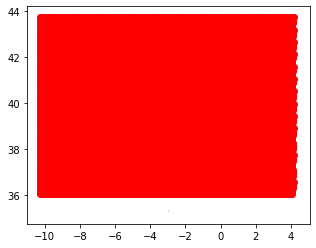

In [10]:
ax=province_gdf.plot();
candidate_points_gdf.plot(ax=ax,color='red');

In [11]:
final_points_gdf = gpd.sjoin(candidate_points_gdf, province_gdf, how="inner", op='within')
final_points_gdf.head()

,id,lat,lon,geometry,index_right,NATCODE,NAMEUNIT,CODEUNIT
19,20,43.748338,-7.905784,POINT (-7.90578 43.74834),29,34121500000,A Coruña,15
135,136,43.658506,-8.033677,POINT (-8.03368 43.65851),29,34121500000,A Coruña,15
136,137,43.658506,-7.909508,POINT (-7.90951 43.65851),29,34121500000,A Coruña,15
137,138,43.658506,-7.785339,POINT (-7.78534 43.65851),29,34121500000,A Coruña,15
251,252,43.568674,-8.161182,POINT (-8.16118 43.56867),29,34121500000,A Coruña,15


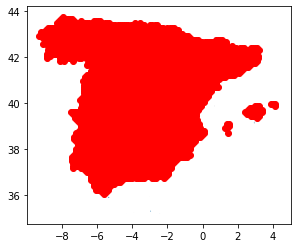

In [12]:
ax=province_gdf.plot();
final_points_gdf.plot(ax=ax,color='red');

Num of points

In [13]:
len(final_points_gdf)

4981

In [14]:
fs = fs.Foursquare(client_id=FOURSQUARE_API_CLIENT_ID, client_secret=FOURSQUARE_API_CLIENT_SECRET)

In [ ]:
stats = []
all_venues = []
fs_target_category = '4bf58dd8d48988d1fa931735' #hotel category id

for i,p in tqdm_notebook(final_points_gdf.iterrows()):
    lon = p['geometry'].x
    lat = p['geometry'].y
    
    try:
        venues = fs.venues.search(params={'categoryId': '{}'.format(fs_target_category),'ll': '{},{}'.format(lat,lon), 
                                                  'radius': (distance+20)*1000})

        all_venues= all_venues + venues['venues']    
        stats.append((i, len(venues['venues']), lat, lon))
        print((len(venues['venues']), len(all_venues)), end=' ')
    except:
        print("Quota_exceeded. Sleep for 24 hours... ")
        time.sleep(24 * 60 * 60) # Wait for 24 hours
        
stats_df = pd.DataFrame.from_records(stats, columns='id num_hotels lat lon'.split())
stats_df = stats_df.set_index('id')
final_points_gdf['num_hotels'] = stats_df['num_hotels']

<ipython-input-15-e0ef5de0a437>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,p in tqdm_notebook(final_points_gdf.iterrows()):


0it [00:00, ?it/s]

Unknown error. meta: {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '6098f72a30ee16366075dde5'}
Unknown error. meta: {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '6098f72b76055e5981f1e02d'}
Unknown error. meta: {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '6098f72d1d1a5131ee72573e'}


Quota_exceeded. Sleep for 24 hours... 
(26, 26) (26, 52) (26, 78) (30, 108) (29, 137) (27, 164) (27, 191) (29, 220) (30, 250) (30, 280) (28, 308) (28, 336) (29, 365) (30, 395) (27, 422) (29, 451) (29, 480) (29, 509) (29, 538) (29, 567) (28, 595) (30, 625) (29, 654) (29, 683) (29, 712) (29, 741) (29, 770) (29, 799) (28, 827) (29, 856) (28, 884) (28, 912) (29, 941) (28, 969) (29, 998) (29, 1027) (29, 1056) (29, 1085) (29, 1114) (29, 1143) (28, 1171) (28, 1199) (29, 1228) (28, 1256) (28, 1284) (29, 1313) (29, 1342) (29, 1371) (30, 1401) (28, 1429) (28, 1457) (28, 1485) (28, 1513) (28, 1541) (29, 1570) (29, 1599) (29, 1628) (30, 1658) (29, 1687) (30, 1717) (30, 1747) (28, 1775) (28, 1803) (28, 1831) (29, 1860) (29, 1889) (29, 1918) (30, 1948) (30, 1978) (30, 2008) (28, 2036) (28, 2064) (29, 2093) (29, 2122) (30, 2152) (30, 2182) (27, 2209) (29, 2238) (26, 2264) (25, 2289) (25, 2314) (28, 2342) (27, 2369) (27, 2396) (28, 2424) (27, 2451) (27, 2478) (27, 2505) (27, 2532) (28, 2560) (27, 2587

Unknown error. meta: {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '609a4a416ae5300c634ae34e'}
Unknown error. meta: {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '609a4a43c81c5a0f9e3ad41b'}
Unknown error. meta: {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '609a4a443270d362af85d405'}


Quota_exceeded. Sleep for 24 hours... 


In [ ]:
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d-%H-%M-%S")

In [ ]:
with open(os.path.join('data',f"fs_hotels_{dt_string}.dat"), "wb") as fp:   #Pickling
    pickle.dump(all_venues, fp)

In [ ]:
stats_df.to_csv(os.path.join('data', f'fs_stats_{dt_string}.csv'))

## General stats from FS data

In [6]:
import pickle
import os
import pandas as pd

In [3]:
with open(os.path.join('data',"fs_hotels_2021-05-17-11-41-28.dat"), "rb") as fp:   #Pickling
    f = pickle.load(fp)

In [9]:
fs_hotels_df =pd.DataFrame(f)
fs_hotels_df.head()

,id,name,location,categories,referralId,hasPerk,venuePage
0,4dab45976a2303012f20864a,Leira Antiga,"{'lat': 43.661271, 'lng': -8.039247, 'labeledL...","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1620723883,False,NaN
1,4c90161e6fbf224b71e9508f,Hotel Spa Sercotel Odeón,"{'address': 'Rúa Cataluña, 20', 'crossStreet':...","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1620723883,False,NaN
2,4bd1b52f5e0cce7235dea184,Hotel Parador de Ferrol,{'address': 'Praza do Almirante Fernández Mart...,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1620723883,False,NaN
3,4f9fdb4be4b0410091f3574f,Surftrip Galice Surf Camp,"{'lat': 43.51539074250371, 'lng': -8.312322101...","[{'id': '4bf58dd8d48988d1ee931735', 'name': 'H...",v-1620723883,False,NaN
4,55af4a35498e6a04ba747a6c,Hotel Valcarce,"{'address': 'Polígono Ind. Río do Pozo', 'cros...","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",v-1620723883,False,NaN


In [10]:
fs_hotels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128820 entries, 0 to 128819
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          128820 non-null  object
 1   name        128820 non-null  object
 2   location    128820 non-null  object
 3   categories  128820 non-null  object
 4   referralId  128820 non-null  object
 5   hasPerk     128820 non-null  bool  
 6   venuePage   6119 non-null    object
dtypes: bool(1), object(6)
memory usage: 6.0+ MB


In [11]:
fs_hotels_df.drop_duplicates('id').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7375 entries, 0 to 128788
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7375 non-null   object
 1   name        7375 non-null   object
 2   location    7375 non-null   object
 3   categories  7375 non-null   object
 4   referralId  7375 non-null   object
 5   hasPerk     7375 non-null   bool  
 6   venuePage   337 non-null    object
dtypes: bool(1), object(6)
memory usage: 410.5+ KB


In [ ]:
print("That's all folks")

# Test Code

In [ ]:
distance = 50
fs_target_category = '4bf58dd8d48988d1fa931735' #hotel category id

#fsh = FoursquareHandler(FOURSQUARE_API_CLIENT_ID,FOURSQUARE_API_CLIENT_SECRET)
fs = fs.Foursquare(client_id=FOURSQUARE_API_CLIENT_ID, client_secret=FOURSQUARE_API_CLIENT_SECRET)

stats = []

lat = north_west[0]
all_venues = []
while lat >= south_east[0]:
    lon= north_west[1]
    while lon <= south_east[1]:
        _,lon = get_new_point(lat, lon, distance, 1.57)
        try:
            #venues= fsh.getVenuesAround((lat, lon), fs_target_category, distance+20)
            venues = fs.venues.search(params={'categoryId': '{}'.format(fs_target_category),'ll': '{},{}'.format(lat,lon), 
                                              'radius': distance+20, 
                                              'intent': 'browse'})
            
            all_venues= all_venues + venues['venues']    
            stats.append((len(venues['venues']), lat, lon))
            print((len(venues['venues']), len(all_venues)), end=' ')
        except:
            print("Quota_exceeded. Sleep for 60 minutes... ")
            time.sleep(60*60)
    lat,_ = get_new_point(lat, lon, distance, 3.1415)    

In [ ]:
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d-%H-%M-%S")

In [ ]:
with open(os.path.join('data',f"fs_hotels_{dt_string}.dat"), "wb") as fp:   #Pickling
    pickle.dump(all_venues, fp)

In [ ]:
stats_df = pd.DataFrame.from_records(stats, columns='num_hotels lat lon'.split())
stats_df.head()

In [ ]:
stats_df

In [ ]:
stats_df.to_csv(os.path.join('data', f'fs_stats_{dt_string}.csv'))